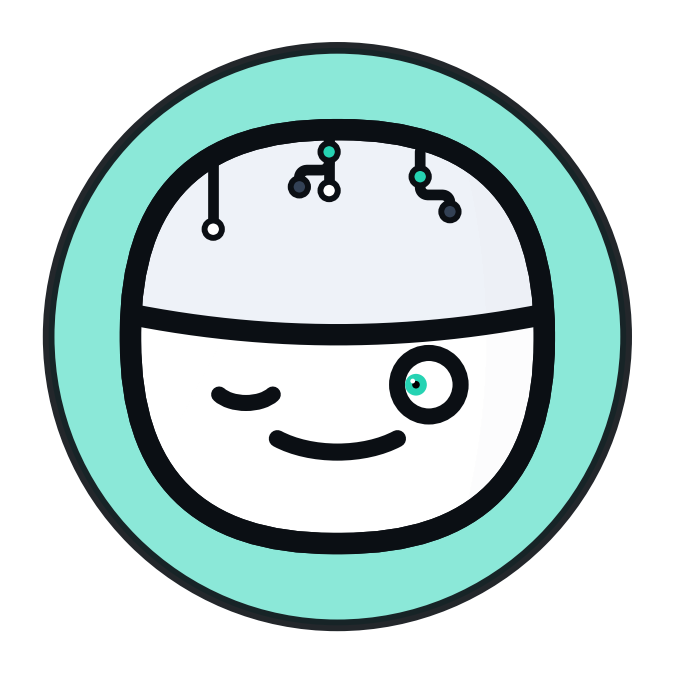

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys

from draw_face_helpers import (
    draw_face_patch,
    draw_face_brain,
    add_circle_lens_shadow,
    add_one_brain_circuit_from_brain_top,
    add_rect_bent_double_node_from_brain_top,
    draw_eyes,
    add_smile,
    background_circle,
)

# ============================
# Global style (Smart-Tinmen)
# ============================

# Geometry / stroke (cleaner, more “product/prototype”)
FIGSIZE = (6, 6)
DPI = 140
LW_OUTLINE = 11

FACE_SIZE = 0.86
FACE_ROUND_TOP = 0.44
FACE_ROUND_BOT = 0.44

# Fills (modern, prototyping-company friendly: neutral + mint accent)
BRAIN_COLOR = "#EEF2F8"   # cool light gray-blue
FACE_COLOR  = "#FFFFFF"   # crisp white

LINE_COLOR  = "#0B0F14"   # deep ink (less harsh than pure black)

# Lens shading baseline (will be overridden by hue-shifted bands below)
LENS_BRAIN = "#6D28D9"
LENS_FACE  = "#FB7185"
LENS_ALPHA = 1

# Circuits
WIRE_COLOR = LINE_COLOR
NODE_LED   = "#26D3B3"    # brighter “prototype LED”
NODE_METAL = "#334155"
NODE_EDGE  = LINE_COLOR

# Background ring (mint “lab/prototyping” vibe)
BACKGROUND_COLOR = "#7FE6D4"  # mint ring

# Eyes
EYE_IRIS   = NODE_LED
EYE_PUPIL_RATIO = 0.35
EYE_SPEC_RATIO  = 0.22
EYE_GAZE_STRENGTH = 0.45

# Expression tweak
EYES_CY = 0.42
SMILE_Y = -0.14
SMILE_W = 0.36
SMILE_H = 0.20

SHADOW_Z = 28
CIRCUIT_Z = 40


# ----------------------------
# Hue-shifted lens bands (driven by FACE_COLOR + BRAIN_COLOR)
# ----------------------------

def _hex_to_rgb01(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16)/255.0 for i in (0, 2, 4))

def _rgb01_to_hex(rgb):
    return "#{:02X}{:02X}{:02X}".format(
        int(round(rgb[0]*255)),
        int(round(rgb[1]*255)),
        int(round(rgb[2]*255)),
    )

def hue_shift_palette(base_hex, n=5, spread=0.18, sat_boost=0.20, val_boost=0.06):
    """
    Build n colors by sweeping hue around the base color in HSV space.
    spread ~ how wide the hue sweep is (0..0.5).
    """
    r, g, b = _hex_to_rgb01(base_hex)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # Make the bands “lens-like” (a bit more saturated / slightly brighter)
    s = min(1.0, s + sat_boost)
    v = min(1.0, v + val_boost)

    if n == 1:
        hs = [h]
    else:
        hs = [ (h + (t - 0.5) * 2 * spread) % 1.0 for t in np.linspace(0, 1, n) ]

    out = []
    for hh in hs:
        rr, gg, bb = colorsys.hsv_to_rgb(hh, s, v)
        out.append(_rgb01_to_hex((rr, gg, bb)))
    return out


# --- lens bands: simpler = more logo-like ---
N_BANDS = 1  # was 3


# no need to reverse when N_BANDS=1
# brain_band_colors = brain_band_colors[::-1]


def derive_cold_tint(base_hex, hue_shift=-0.06, sat_floor=0.35, val_floor=0.75, val_scale=0.92):
    r, g, b = _hex_to_rgb01(base_hex)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # If the base is near-gray (low saturation), force a usable “glass” saturation
    s = max(s, sat_floor)

    # Nudge hue colder, and slightly darken so it reads like a shadow
    h = (h + hue_shift) % 1.0
    v = max(v * val_scale, val_floor)

    rr, gg, bb = colorsys.hsv_to_rgb(h, s, v)
    return _rgb01_to_hex((rr, gg, bb))

# Face shadow: slightly toward cyan/blue from FACE_COLOR
COLD_TINT_FACE  = derive_cold_tint(FACE_COLOR,  hue_shift=-0.07, sat_floor=0.30, val_floor=0.72, val_scale=0.90)

# Brain shadow: pushed more toward violet/indigo from BRAIN_COLOR (distinct from face)
COLD_TINT_BRAIN = derive_cold_tint(BRAIN_COLOR, hue_shift=+0.10, sat_floor=0.45, val_floor=0.68, val_scale=0.88)


def cold_shadow_palette(
    base_hex,
    n=5,
    sat_min=0.18,
    sat_max=0.38,
    val_min=0.92,
    val_max=0.70,
):
    """
    Same hue, cooler family. Varies saturation + value across bands.
    """
    r, g, b = _hex_to_rgb01(base_hex)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    sats = np.linspace(sat_min, sat_max, n)
    vals = np.linspace(val_min, val_max, n)

    out = []
    for ss, vv in zip(sats, vals):
        rr, gg, bb = colorsys.hsv_to_rgb(h, ss, vv)
        out.append(_rgb01_to_hex((rr, gg, bb)))
    return out

face_band_colors  = cold_shadow_palette(
    COLD_TINT_FACE,
    n=N_BANDS,
    sat_min=0.08,  # tighter + cleaner
    sat_max=0.14,
    val_min=0.97,
    val_max=0.90,
)

brain_band_colors = cold_shadow_palette(
    COLD_TINT_BRAIN,
    n=N_BANDS,
    sat_min=0.10,
    sat_max=0.18,
    val_min=0.96,
    val_max=0.86,
)


# usually nicer if brain is a touch “deeper” nearer the edge
brain_band_colors = brain_band_colors[::-1]

# (Optional but usually nicer): reverse brain bands so the “energy” reads top-to-bottom
brain_band_colors = brain_band_colors[::-1]

def add_lens_shadow_subdivisions_with_colors(
    ax,
    face_outline,
    center_start,
    center_end,
    radius,
    face_colors,   # list like ["#FB7185", "#F97316", ...]
    brain_colors,  # list like ["#6D28D9", "#7C3AED", ...]
    region="outside",
    prefer="right",
    zorder=28,
    alpha=1.0,
):
    """
    Draw N shadows between center_start and center_end.
    Uses face_colors[i] and brain_colors[i] for each subdivision i.
    """
    if len(face_colors) != len(brain_colors):
        raise ValueError("face_colors and brain_colors must have the same length")

    n = len(face_colors)
    if n == 0:
        return

    c0 = np.array(center_start, dtype=float)
    c1 = np.array(center_end, dtype=float)

    if n == 1:
        centers = [tuple((c0 + c1) / 2.0)]
    else:
        ts = np.linspace(0.0, 1.0, n)
        centers = [tuple(c0 * (1 - t) + c1 * t) for t in ts]

    for cc, fc, bc in zip(centers, face_colors, brain_colors):
        add_circle_lens_shadow(
            ax,
            face_outline=face_outline,
            circle_center=cc,
            radius=radius,
            brain_shadow_color=bc,
            face_shadow_color=fc,
            alpha=alpha,
            region=region,
            prefer=prefer,
            zorder=zorder,
        )


def demo():
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    #ax.set_xlim(-0.1, 1.1)
    #ax.set_ylim(-0.1, 1.1)
    ax.set_aspect("equal")
    ax.axis("off")
    fig.canvas.draw()

    # Face outline (base)
    face_outline = draw_face_patch(
        width=FACE_SIZE,
        height=FACE_SIZE,
        angle_top_to_bottom=0,
        rounding_top=FACE_ROUND_TOP,
        rounding_bottom=FACE_ROUND_BOT,
        cx=0.5, cy=0.5,
        facecolor="none",
        edgecolor=LINE_COLOR,
        lw=LW_OUTLINE,
        zorder=20,
    )
    ax.add_patch(face_outline)

    # Brain/face split fills
    brain_fill, face_fill, sep_line = draw_face_brain(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y_pos_px=30,
        curvature_px=-55,
        curve_dir="down",
        fill_pad_px=0,
        sep_n=700,
        boundary_interp=220,
        lw=LW_OUTLINE,
        brain_color=BRAIN_COLOR,
        face_color=FACE_COLOR,
        line_color=LINE_COLOR,
    )


    add_lens_shadow_subdivisions_with_colors(
        ax,
        face_outline,
        center_start=(0.5 - 1.22, 0.5),   # slightly tighter
        center_end=(0.5 - 1.20, 0.5),
        radius=1.52,
        face_colors=face_band_colors,
        brain_colors=brain_band_colors,
        alpha=0.035,                      # was 0.06 (cleaner, less “airbrush”)
        zorder=SHADOW_Z,
    )

    # Two straight hanging circuits
    add_one_brain_circuit_from_brain_top(
        ax, face_outline,
        center_shift=-0.02,
        length_px=80,
        node_r=0.018,
        node_facecolor="#FFFFFF",
        node_edgecolor=NODE_EDGE,
        wire_lw=LW_OUTLINE * 0.50,
        wire_color=WIRE_COLOR,
        zorder=CIRCUIT_Z,
    )

    add_one_brain_circuit_from_brain_top(
        ax, face_outline,
        center_shift=-0.30,
        length_px=80,
        node_r=0.018,
        node_facecolor="#FFFFFF",
        node_edgecolor=NODE_EDGE,
        wire_lw=LW_OUTLINE * 0.50,
        wire_color=WIRE_COLOR,
        zorder=CIRCUIT_Z,
    )

    # Left bent circuit (mirrored)
    add_rect_bent_double_node_from_brain_top(
        ax, face_outline,
        center_shift=-0.02,
        length_px=75,
        bend_px=40,
        bend_at=0.7,
        bend_dir=-1,
        corner_px=12,
        corner_n=7,
        node1_on="vertical1",
        node1_u=0.58,
        node_facecolor1=NODE_LED,
        node_facecolor2=NODE_METAL,
        node_edgecolor=NODE_EDGE,
        node_r=0.018,
        wire_color=WIRE_COLOR,
        wire_lw=LW_OUTLINE * 0.50,
        zorder=CIRCUIT_Z,
    )

    # Right bent circuit
    add_rect_bent_double_node_from_brain_top(
        ax, face_outline,
        center_shift=0.20,
        length_px=75,
        bend_px=40,
        bend_at=0.7,
        bend_dir=+1,
        corner_px=12,
        corner_n=7,
        node1_on="vertical1",
        node1_u=0.58,
        node_facecolor1=NODE_LED,
        node_facecolor2=NODE_METAL,
        node_edgecolor=NODE_EDGE,
        node_r=0.018,
        wire_color=WIRE_COLOR,
        wire_lw=LW_OUTLINE * 0.50,
        zorder=CIRCUIT_Z,
    )

    # Eyes
    draw_eyes(
        ax, face_outline,
        cx=0.5, cy=EYES_CY,
        open_left=False, open_right=True,
        eye_dx=0.19, eye_dy=-0.02,
        r=0.066,
        wink_lw=LW_OUTLINE * 0.75,
        outline_color=LINE_COLOR,
        iris_color_left=EYE_IRIS,
        iris_color_right=EYE_IRIS,
        ring_ratio=0.10,
        iris_ratio=0.38,
        pupil_ratio=EYE_PUPIL_RATIO,
        spec_ratio=EYE_SPEC_RATIO,
        spec_offset=(0.30, 0.34),
        iris_offset_y=0.0,
        gaze_left=(1.0, 0.0),
        gaze_right=(-1.0, 0.0),
        gaze_strength=EYE_GAZE_STRENGTH,
        aa_shrink=0.995,
    )

    # Smile
    add_smile(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y=SMILE_Y,
        w=SMILE_W, h=SMILE_H,
        theta1=210, theta2=330,
        lw=LW_OUTLINE * 0.80,
        color=LINE_COLOR,
    )

    # Background circle
    background_circle(
        ax,
        center=(0.5, 0.5),
        radius=0.60,      # slightly larger ring
        color=BACKGROUND_COLOR,
        alpha=0.90,       # more solid, logo-like
        edgecolor="#0B0F14",
        lw=6,
        zorder=0
    )


    # Redraw outline on top (prevents shadow bleed)
    face_outline_top = draw_face_patch(
        width=FACE_SIZE,
        height=FACE_SIZE,
        angle_top_to_bottom=0,
        rounding_top=FACE_ROUND_TOP,
        rounding_bottom=FACE_ROUND_BOT,
        cx=0.5, cy=0.5,
        facecolor="none",
        edgecolor=LINE_COLOR,
        lw=LW_OUTLINE,
        zorder=1000,
    )
    ax.add_patch(face_outline_top)
    ax.relim()
    ax.autoscale_view()
    
    # add a little breathing room so strokes/ring don’t touch the edge
    ax.margins(0.06)
    #plt.tight_layout(pad=0.0)

    plt.show()
    return face_outline


if __name__ == "__main__":
    demo()
